# Rev 스타일/기능 변경
- 색각이상 친화 팔레트 적용 (seaborn 'colorblind', matplotlib 'tab10'/'cividis').
- 범례 대비/가독성 강화 (배경/테두리/폰트).
- 저장 경로는 기존과 동일(`LaTeX/Figures/...`) 권장.



In [21]:
# 전역 스타일 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_palette('colorblind')
except Exception:
    pass
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.get_cmap('tab10').colors)
mpl.rcParams['image.cmap'] = 'cividis'
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 13
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.framealpha'] = 0.9
mpl.rcParams['legend.fontsize'] = 10



## Fig2 Rev: Jeju 신호에 대한 EMD/EEMD/CEEMDAN 비교
- Data_mid 내 사전 계산된 EEMD/CEEMDAN 결과 사용
- PyEMD `EMD`로 기준 분해 재계산 (Jeju)
- 3열(EMD/EEMD/CEEMDAN)×4행(원신호/IMF1/IMF2/Trend) 패널 생성


In [22]:
# 데이터 로드 및 분해 준비
from pathlib import Path
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from PyEMD import EMD

STATION = 'Jeju'
TRIALS = 2048
EPSILON = 0.6
MID_DIR = Path('Data_mid')

ce_path = MID_DIR / f"{STATION}_CEEMDAN_{TRIALS}_{EPSILON}.parquet"
eemd_path = MID_DIR / f"{STATION}_EEMD_{TRIALS}_{EPSILON}.parquet"

df_ceemdan = pd.read_parquet(ce_path)
df_eemd = pd.read_parquet(eemd_path)

signal = df_ceemdan.sum(axis=1)
time_index = pd.to_datetime(signal.index)

emd = EMD()
imfs_emd = emd.emd(signal.values)
df_emd = pd.DataFrame(imfs_emd.T, index=time_index, columns=[f'IMF_{i}' for i in range(imfs_emd.shape[0])])

methods = OrderedDict([
    ('EMD', df_emd),
    ('EEMD', df_eemd),
    ('CEEMDAN', df_ceemdan),
])



Saved LaTeX/Figures/Figure2_CEEMDAN.pdf


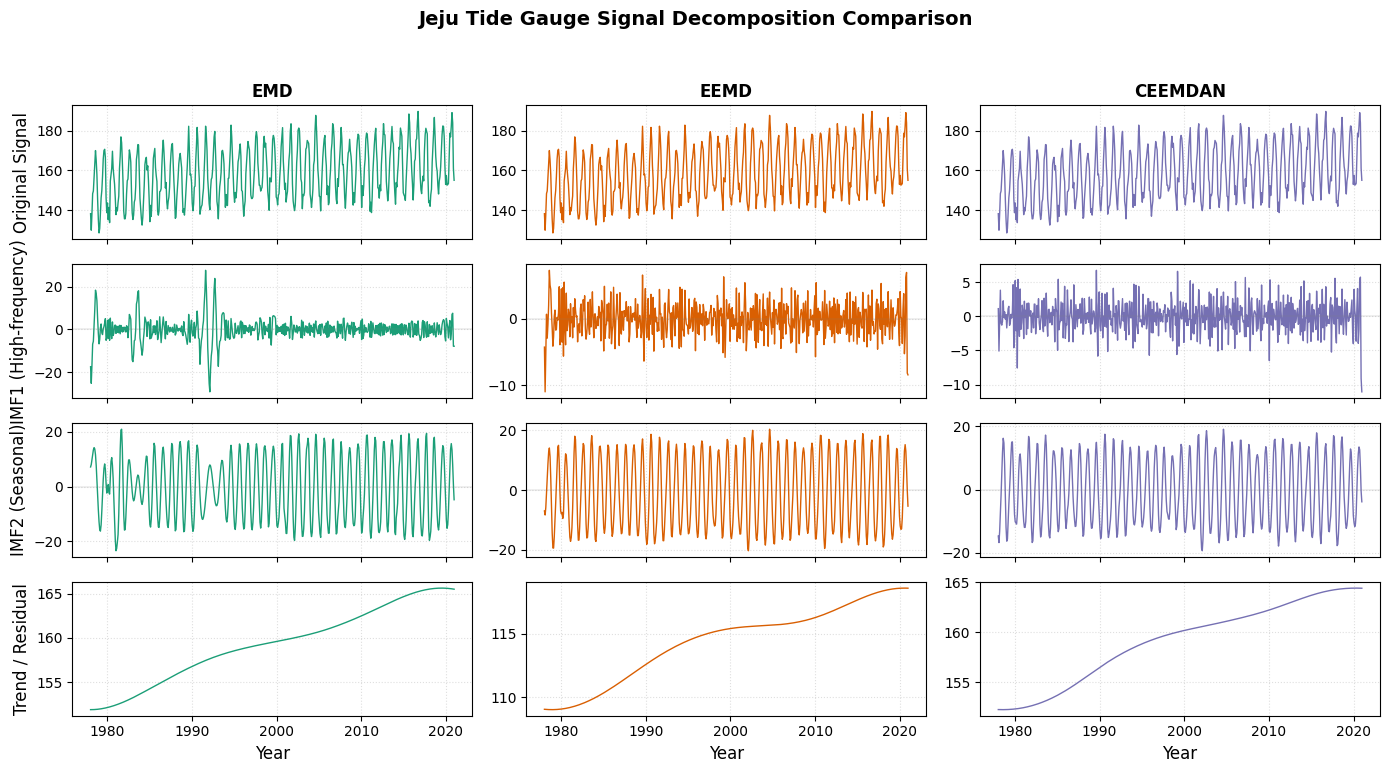

In [23]:
# 비교 패널 플롯 및 저장
component_specs = [
    {'label': 'Original Signal', 'index': None, 'axhline': False},
    {'label': 'IMF1 (High-frequency)', 'index': 0, 'axhline': True},
    {'label': 'IMF2 (Seasonal)', 'index': 1, 'axhline': True},
    {'label': 'Trend / Residual', 'index': 'trend', 'axhline': False},
]
method_colors = {
    'EMD': '#1b9e77',
    'EEMD': '#d95f02',
    'CEEMDAN': '#7570b3',
}

fig, axes = plt.subplots(len(component_specs), len(methods), figsize=(14, 8), sharex=True)
axes = np.atleast_2d(axes)

for col, (method_name, df_method) in enumerate(methods.items()):
    arr = df_method.to_numpy().T
    for row, spec in enumerate(component_specs):
        ax = axes[row, col]
        label = spec['label']
        idx = spec['index']
        if idx is None:
            series = signal.values
        elif idx == 'trend':
            if method_name == 'EEMD' and arr.shape[0] >= 2:
                series = arr[-2]
            else:
                series = arr[-1] if arr.shape[0] > 0 else signal.values
        else:
            idx_clamped = min(idx, arr.shape[0]-1)
            series = arr[idx_clamped]
        ax.plot(time_index, series, color=method_colors.get(method_name, f'C{col}'), lw=1.0)
        if spec['axhline']:
            ax.axhline(0, color='gray', lw=0.3, alpha=0.6)
        if col == 0:
            ax.set_ylabel(label)
        if row == 0:
            ax.set_title(method_name, fontsize=12, weight='bold')
        ax.grid(True, ls=':', alpha=0.4)

for ax in axes[-1, :]:
    ax.set_xlabel('Year')
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Jeju Tide Gauge Signal Decomposition Comparison', fontsize=14, weight='bold')
fig.tight_layout(rect=[0, 0.02, 1, 0.95])
fig.savefig('LaTeX/Figures/Figure2_CEEMDAN.pdf', dpi=400, bbox_inches='tight')
print('Saved LaTeX/Figures/Figure2_CEEMDAN.pdf')



Saved LaTeX/SUPP/SFig_full_IMF_comparison.pdf


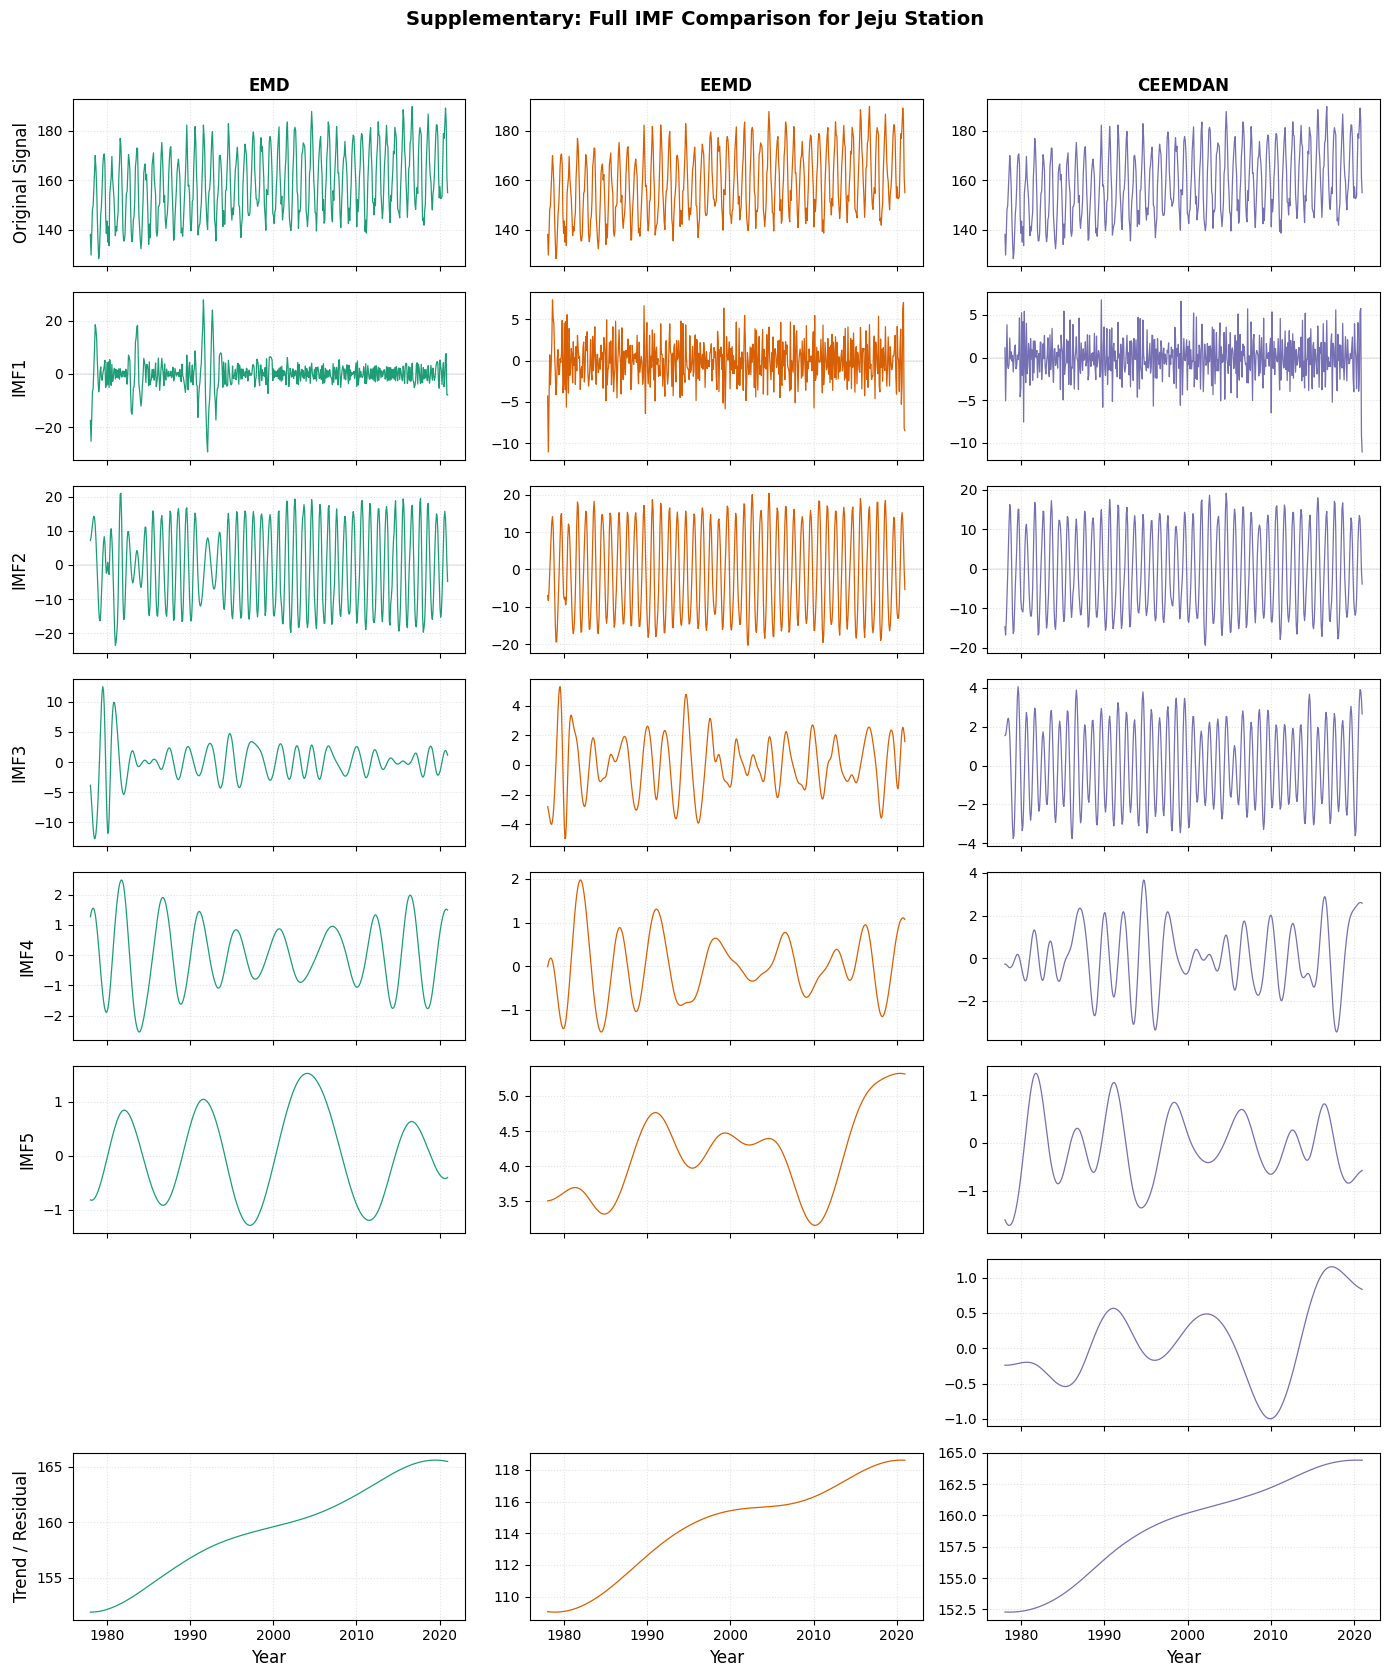

In [24]:
# Supplementary Figure: full IMF comparison
method_components = {}
for method_name, df_method in methods.items():
    arr = df_method.to_numpy().T
    if arr.shape[0] == 0:
        method_components[method_name] = {'imfs': [], 'trend': signal.values}
        continue
    if method_name == 'EEMD' and arr.shape[0] >= 2:
        trend_component = arr[-2]
        imfs = arr[:-2]
    else:
        trend_component = arr[-1]
        imfs = arr[:-1]
    method_components[method_name] = {
        'imfs': list(imfs),
        'trend': trend_component,
    }

max_imf_count = max((len(v['imfs']) for v in method_components.values()), default=0)
row_labels = ['Original Signal'] + [f'IMF{i}' for i in range(1, max_imf_count + 1)] + ['Trend / Residual']

fig2, axes2 = plt.subplots(len(row_labels), len(methods), figsize=(14, 2.2 * len(row_labels)), sharex=True)
axes2 = np.atleast_2d(axes2)

for col, method_name in enumerate(methods.keys()):
    data = method_components[method_name]
    for row, label in enumerate(row_labels):
        ax = axes2[row, col]
        if row == 0:
            series = signal.values
        elif label.startswith('IMF'):
            idx = int(label.replace('IMF', '')) - 1
            imfs = data['imfs']
            if idx >= len(imfs):
                ax.axis('off')
                continue
            series = imfs[idx]
        else:  # Trend
            series = data['trend']
        ax.plot(time_index, series, color=method_colors.get(method_name, f'C{col}'), lw=0.9)
        if label in ('IMF1', 'IMF2'):
            ax.axhline(0, color='gray', lw=0.3, alpha=0.6)
        if col == 0:
            ax.set_ylabel(label)
        if row == 0:
            ax.set_title(method_name, fontsize=12, weight='bold')
        ax.grid(True, ls=':', alpha=0.35)

for ax in axes2[-1, :]:
    ax.set_xlabel('Year')
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig2.suptitle('Supplementary: Full IMF Comparison for Jeju Station', fontsize=14, weight='bold')
fig2.tight_layout(rect=[0, 0.03, 1, 0.97])
fig2.savefig('LaTeX/SUPP/SFig_full_IMF_comparison.pdf', dpi=400, bbox_inches='tight')
print('Saved LaTeX/SUPP/SFig_full_IMF_comparison.pdf')

